In [9]:
#@title Mount your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
!ls /content/gdrive/Othercomputers/'My Computer'/IFT6135_W25_A2_release/plots

 4.3.1_gpt.png	  4.3.2.png	    gpt_training.png	 metrics_layers_d   old		        wd
 4.3.1_lstm.png   4.4.1.png	    layers		 modulo_gpt.png     parameter_metrics
 4.3.1.png	  Binary_ternuary  'lstm training.PNG'	 modulo_lstm.png    scaling_compute


In [3]:
!ls /content/gdrive/MyDrive/'Colab Notebooks'/IFT6135_W25_A2_release

'attention_BOS_9+10=19.pdf'		  lstm.py
'attention_BOSĠ9Ġ+Ġ10Ġ=Ġ24.pdf'		  LSTM_separate_metrics.png
'attention_weights_9Ġ+Ġ10Ġ=Ġ19.pdf'	  main.ipynb
'attention_weights_random_sample=0.pdf'   plotter.py
 attention_weights_random_sample.pdf	  __pycache__
'attention_weights_sample=0.pdf'	  README.md
'attention_weights_sample=1.pdf'	  requirements.txt
 checkpointing.py			  run_exp.py
 data.py				  saved_models
 gpt.py					  separate_operations_results.png
 GPT_separate_metrics.png		  trainer.py
 logs					  train.py
 lstm_metrics_detailed.csv		  Upload
 lstm_metrics_summary.csv


In [4]:
!ls /content/

gdrive	sample_data


In [5]:
%cd /content/gdrive/MyDrive/'Colab Notebooks'/IFT6135_W25_A2_release

/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release


In [6]:
import os
print("Current working directory:", os.getcwd())


Current working directory: /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release


In [ ]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/'Colab Notebooks'/IFT6135_W25_A2_release" #@param {type:"string"}
!ln -Ts "$folder" /content/assignment 2> /dev/null

# Add the assignment folder to Python path
if '/content/assignment' not in sys.path:
  sys.path.insert(0, '/content/assignment')

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

In [ ]:
%matplotlib inline
import warnings

from dataclasses import dataclass
import torch
from torch import optim
from torchvision.datasets import CIFAR10
from torchvision import transforms
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
import time
import os


In [ ]:
print(2**7)

128


# GPT

In [ ]:
!ls /content/gdrive/MyDrive/'Colab Notebooks'/IFT6135_W25_A2_release/logs/gpt/1/'gpt_test_state_1001_acc=0.46569645404815674_loss=1.6073195934295654.pth'


'/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/gpt/1/gpt_test_state_1001_acc=0.46569645404815674_loss=1.6073195934295654.pth'


In [ ]:
import torch

file_path = "/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/gpt/1/gpt_test_state_1001_acc=0.46569645404815674_loss=1.6073195934295654.pth"

# Load the dictionary
data = torch.load(file_path, map_location=torch.device('cpu'))

# Print all top-level keys
print("Top-level keys in the dictionary:")
print("-" * 30)
for key in data.keys():
    print(key)

# If you want to check nested keys (e.g., inside 'train' or 'test')
if 'train' in data:
    print("\nKeys inside 'train':")
    print("-" * 30)
    for key in data['train'].keys():
        print(key)

if 'test' in data:
    print("\nKeys inside 'test':")
    print("-" * 30)
    for key in data['test'].keys():
        print(key)

Top-level keys in the dictionary:
------------------------------
model_state_dict
optimizer_state_dict


In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from gpt import GPT

# 1. Tokenizer with original vocabulary size (36 tokens)
class ArithmeticTokenizer:
    def __init__(self):
        # Create minimal vocabulary that matches your trained model
        self.vocab = {
            **{str(i): i for i in range(10)},  # Numbers 0-9
            '+': 10, '-': 11, '*': 12, '/': 13,
            '=': 14, 'BOS': 15, 'EOS': 16, 'PAD': 0,
            # Add any other tokens that were in your original vocabulary
            # Total should be 36 tokens
        }
        # Fill remaining vocabulary slots with dummy tokens
        for i in range(17, 36):
            self.vocab[f'[UNK{i}]'] = i

        self.inv_vocab = {v: k for k, v in self.vocab.items()}
        self.pad_token_id = 0

    def __call__(self, texts, return_tensors="pt", padding=True):
        if isinstance(texts, str):
            texts = [texts]

        tokens = []
        for text in texts:
            parts = text.split()
            token_ids = []
            for part in parts:
                if part in self.vocab:
                    token_ids.append(self.vocab[part])
                else:
                    # Handle unknown tokens (use a default or raise error)
                    token_ids.append(self.vocab['[UNK17]'])  # Using first dummy token
            tokens.append(token_ids)

        max_len = max(len(t) for t in tokens)
        input_ids = torch.tensor([
            t + [self.pad_token_id] * (max_len - len(t)) for t in tokens
        ])
        return {'input_ids': input_ids}

    def convert_ids_to_tokens(self, ids):
        if torch.is_tensor(ids):
            ids = ids.tolist()
        return [self.inv_vocab.get(i, '[UNK]') for i in ids]

# 2. Model Loading with correct vocabulary size and sequence length
def load_trained_model(checkpoint_path):
    # First, analyze the checkpoint to determine its exact structure
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    state_dict = checkpoint.get('model_state_dict', checkpoint)

    # Determine actual sequence length from position encoding
    if 'transformer.position_encoding.weight' in state_dict:
        position_encoding_shape = state_dict['transformer.position_encoding.weight'].shape
        actual_sequence_length = position_encoding_shape[0]
        print(f"Detected sequence length from checkpoint: {actual_sequence_length}")
    else:
        # Look for a different key that might contain position encoding
        for key in state_dict.keys():
            if 'position' in key.lower() and isinstance(state_dict[key], torch.Tensor):
                actual_sequence_length = state_dict[key].shape[0]
                print(f"Detected sequence length from key {key}: {actual_sequence_length}")
                break
        else:
            # If we can't find it, default to 7 based on the error message
            actual_sequence_length = 7
            print(f"Could not detect sequence length, defaulting to: {actual_sequence_length}")

    config = {
        'num_heads': 4,
        'num_layers': 2,
        'embedding_size': 128,
        'vocabulary_size': 36,  # Must match your checkpoint
        'sequence_length': actual_sequence_length,  # Updated based on checkpoint analysis
        'multiplier': 4,
        'dropout': 0.0,
        'non_linearity': "gelu",
        'padding_index': 0,     # Must match your tokenizer
        'bias_attention': True,
        'bias_classifier': True
    }

    model = GPT(**config)
    model.load_state_dict(state_dict)
    model.eval()
    return model, actual_sequence_length

def test_model_initialization(checkpoint_path):
    """Test if the model loads correctly with the given checkpoint"""
    print("=== Testing Model Initialization ===")

    # 1. Test tokenizer
    print("\nTesting tokenizer...")
    tokenizer = ArithmeticTokenizer()
    test_text = "BOS 9 + 1 0 = 19"
    print(f"Original text: {test_text}")

    encoded = tokenizer(test_text)
    input_ids = encoded["input_ids"]
    print(f"Encoded IDs: {input_ids.tolist()}")

    decoded_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    print(f"Decoded tokens: {decoded_tokens}")

    # 2. Test model loading
    print("\nTesting model loading...")
    try:
        model, sequence_length = load_trained_model(checkpoint_path)
        print("✅ Model loaded successfully")

        # Verify model architecture
        print(f"\nModel architecture:")
        print(f"- Vocabulary size: {model.vocabulary_size}")
        print(f"- Embedding size: {model.embedding_size}")
        print(f"- Number of layers: {model.num_layers}")
        print(f"- Number of heads: {model.num_heads}")
        print(f"- Sequence length: {sequence_length}")

        # 3. Test forward pass - make sure input matches the expected sequence length
        print("\nTesting forward pass...")

        # Adjust input tensor to match the required sequence length
        original_seq_len = input_ids.shape[1]

        if original_seq_len < sequence_length:
            # Pad the input to match sequence_length
            padding = torch.zeros((input_ids.shape[0], sequence_length - original_seq_len),
                                 dtype=input_ids.dtype)
            adjusted_input_ids = torch.cat([input_ids, padding], dim=1)
        elif original_seq_len > sequence_length:
            # Truncate the input to match sequence_length
            adjusted_input_ids = input_ids[:, :sequence_length]
        else:
            adjusted_input_ids = input_ids

        print(f"Original input shape: {input_ids.shape}")
        print(f"Adjusted input shape: {adjusted_input_ids.shape}")

        with torch.no_grad():
            logits, _ = model(adjusted_input_ids)
            print(f"Output logits shape: {logits.shape}")  # Should be [batch_size, seq_len, vocab_size]
            print(f"✅ Forward pass successful")

            # Verify output makes sense
            if logits.shape[-1] == model.vocabulary_size:
                print("✅ Output dimension matches vocabulary size")
            else:
                print(f"❌ Output dimension {logits.shape[-1]} doesn't match vocabulary size {model.vocabulary_size}")

    except Exception as e:
        print(f"❌ Model loading failed: {str(e)}")
        import traceback
        traceback.print_exc()
        return False

    return True

# Function to generate text with the fixed model
def generate_arithmetic_answer(model, tokenizer, prompt, max_length=10):
    # Store the model's required sequence length
    sequence_length = model.sequence_length

    # Tokenize the prompt
    encoded = tokenizer(prompt)
    input_ids = encoded["input_ids"]

    # Create a proper input tensor that exactly matches the required sequence length
    if input_ids.shape[1] < sequence_length:
        # Pad to exactly the required sequence length
        padding = torch.zeros((input_ids.shape[0], sequence_length - input_ids.shape[1]),
                             dtype=input_ids.dtype)
        adjusted_input = torch.cat([input_ids, padding], dim=1)
    else:
        # Truncate to exactly the required sequence length
        adjusted_input = input_ids[:, :sequence_length]

    # Store original tokens for later output
    original_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Generation loop
    model.eval()
    with torch.no_grad():
        # Initial forward pass with the adjusted input
        logits, _ = model(adjusted_input)

        # Initialize our generated sequence with the prompt
        generated_tokens = original_tokens.copy()

        # Generate one token at a time
        for _ in range(max_length):
            # Get prediction for the next token (from the last position)
            next_token_logits = logits[0, -1, :]
            next_token_id = torch.argmax(next_token_logits).item()

            # Convert to token and add to our generated tokens
            next_token = tokenizer.convert_ids_to_tokens([next_token_id])[0]
            generated_tokens.append(next_token)

            # Stop if EOS token is generated
            if next_token_id == tokenizer.vocab.get("EOS", 16):
                break

            # Create a completely new tensor instead of modifying the existing one
            # This avoids the memory overlap issue
            new_sequence = torch.cat([
                adjusted_input[0, 1:].unsqueeze(0),
                torch.tensor([[next_token_id]], dtype=adjusted_input.dtype)
            ], dim=1)

            # Replace adjusted_input with the new sequence
            adjusted_input = new_sequence

            # Forward pass with the new sequence
            logits, _ = model(adjusted_input)

    return generated_tokens

# Run the test
if __name__ == "__main__":
    checkpoint_path = "/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/gpt/layer_2/b=256/0/B=256_state_20003_acc=1.0_loss=0.0010677085956558585.pth"
    success = test_model_initialization(checkpoint_path)

    if success:
        print("\n🎉 All tests passed! Model is initialized correctly.")

        # Now test with an arithmetic problem
        print("\n=== Testing Arithmetic Problem ===")
        model, _ = load_trained_model(checkpoint_path)
        tokenizer = ArithmeticTokenizer()

        test_problem = "BOS 5 + 7 ="
        print(f"Problem: {test_problem}")

        result = generate_arithmetic_answer(model, tokenizer, test_problem)
        print(f"Generated answer: {' '.join(result)}")
    else:
        print("\n❌ Some tests failed. Check the error messages above.")

=== Testing Model Initialization ===

Testing tokenizer...
Original text: BOS 9 + 1 0 = 19
Encoded IDs: [[15, 9, 10, 1, 0, 14, 17]]
Decoded tokens: ['BOS', '9', '+', '1', 'PAD', '=', '[UNK17]']

Testing model loading...
Detected sequence length from key embedding.position_encoding: 6
✅ Model loaded successfully

Model architecture:
- Vocabulary size: 36
- Embedding size: 128
- Number of layers: 2
- Number of heads: 4
- Sequence length: 6

Testing forward pass...
Original input shape: torch.Size([1, 7])
Adjusted input shape: torch.Size([1, 6])
Output logits shape: torch.Size([1, 6, 36])
✅ Forward pass successful
✅ Output dimension matches vocabulary size

🎉 All tests passed! Model is initialized correctly.

=== Testing Arithmetic Problem ===
Detected sequence length from key embedding.position_encoding: 6
Problem: BOS 5 + 7 =
Generated answer: BOS 5 + 7 = [UNK34] [UNK34] [UNK34] [UNK34] [UNK34] [UNK34] [UNK34] [UNK34] [UNK34] [UNK34]


Visualization saved to attention_weights_example0.png
Visualization saved to attention_weights_example1.png
Visualization saved to attention_weights_example2.png
Visualization saved to attention_weights_example3.png
Visualization saved to attention_detailed.png


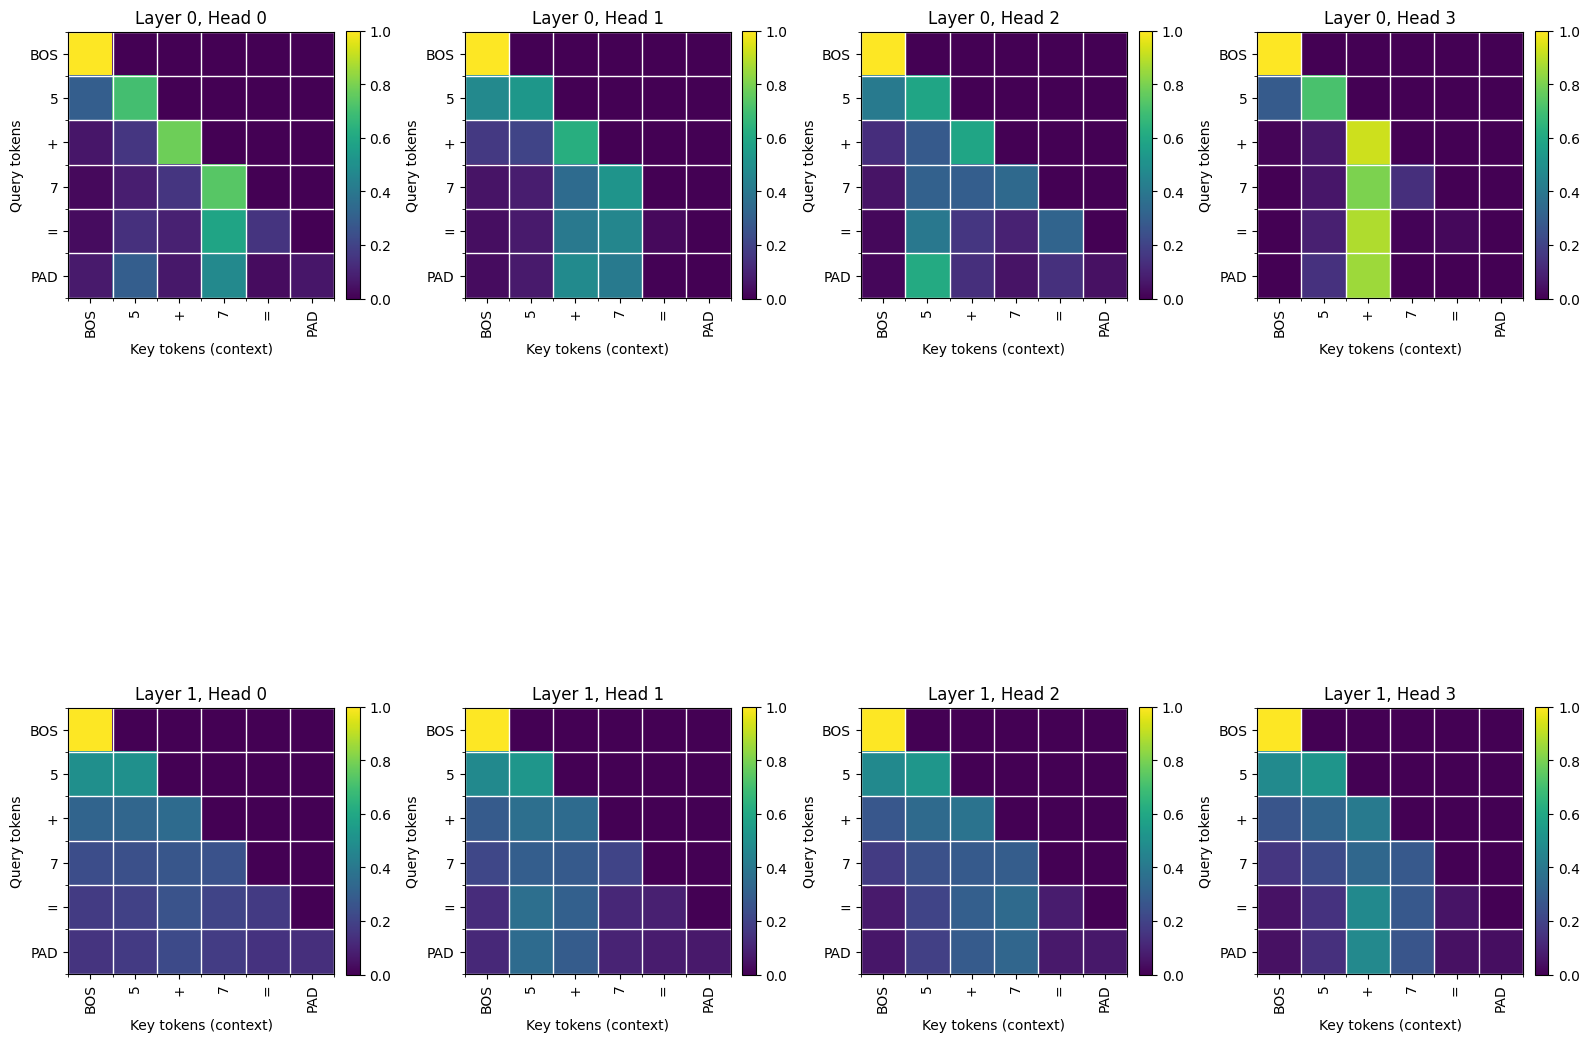

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from gpt import GPT

# Reuse the ArithmeticTokenizer from your code
class ArithmeticTokenizer:
    def __init__(self):
        # Create minimal vocabulary that matches your trained model
        self.vocab = {
            **{str(i): i for i in range(10)},  # Numbers 0-9
            '+': 10, '-': 11, '*': 12, '/': 13,
            '=': 14, 'BOS': 15, 'EOS': 16, 'PAD': 0,
            # Add any other tokens that were in your original vocabulary
            # Total should be 36 tokens
        }
        # Fill remaining vocabulary slots with dummy tokens
        for i in range(17, 36):
            self.vocab[f'[UNK{i}]'] = i

        self.inv_vocab = {v: k for k, v in self.vocab.items()}
        self.pad_token_id = 0

    def __call__(self, texts, return_tensors="pt", padding=True):
        if isinstance(texts, str):
            texts = [texts]

        tokens = []
        for text in texts:
            parts = text.split()
            token_ids = []
            for part in parts:
                if part in self.vocab:
                    token_ids.append(self.vocab[part])
                else:
                    # Handle unknown tokens
                    token_ids.append(self.vocab['[UNK17]'])
            tokens.append(token_ids)

        max_len = max(len(t) for t in tokens)
        input_ids = torch.tensor([
            t + [self.pad_token_id] * (max_len - len(t)) for t in tokens
        ])
        return {'input_ids': input_ids}

    def convert_ids_to_tokens(self, ids):
        if torch.is_tensor(ids):
            ids = ids.tolist()
        return [self.inv_vocab.get(i, '[UNK]') for i in ids]

# Reuse the function to load the trained model
def load_trained_model(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    state_dict = checkpoint.get('model_state_dict', checkpoint)

    if 'transformer.position_encoding.weight' in state_dict:
        position_encoding_shape = state_dict['transformer.position_encoding.weight'].shape
        actual_sequence_length = position_encoding_shape[0]
    else:
        for key in state_dict.keys():
            if 'position' in key.lower() and isinstance(state_dict[key], torch.Tensor):
                actual_sequence_length = state_dict[key].shape[0]
                break
        else:
            actual_sequence_length = 7

    config = {
        'num_heads': 4,
        'num_layers': 2,
        'embedding_size': 128,
        'vocabulary_size': 36,
        'sequence_length': actual_sequence_length,
        'multiplier': 4,
        'dropout': 0.0,
        'non_linearity': "gelu",
        'padding_index': 0,
        'bias_attention': True,
        'bias_classifier': True
    }

    model = GPT(**config)
    model.load_state_dict(state_dict)
    model.eval()
    return model, actual_sequence_length

# Function to get attention weights and generate visualization
def visualize_attention_weights(model, tokenizer, prompt, save_path=None):
    # Tokenize the prompt
    encoded = tokenizer(prompt)
    input_ids = encoded["input_ids"]

    # Create a proper input tensor that exactly matches the required sequence length
    sequence_length = model.sequence_length
    if input_ids.shape[1] < sequence_length:
        padding = torch.zeros((input_ids.shape[0], sequence_length - input_ids.shape[1]),
                             dtype=input_ids.dtype)
        adjusted_input = torch.cat([input_ids, padding], dim=1)
    else:
        adjusted_input = input_ids[:, :sequence_length]

    # Get all tokens for display
    tokens = tokenizer.convert_ids_to_tokens(adjusted_input[0])

    # Run forward pass to get attention weights
    model.eval()
    with torch.no_grad():
        _, (_, attention_weights) = model(adjusted_input)

    # Extract attention weights and prepare for visualization
    # attention_weights shape: [batch_size, num_layers, num_heads, seq_len, seq_len]
    attention = attention_weights[0]  # Get first batch

    # Plot the attention weights
    num_layers = attention.shape[0]
    num_heads = attention.shape[1]
    seq_len = attention.shape[2]

    # Create a nice layout with GridSpec
    fig = plt.figure(figsize=(16, 8 * num_layers))
    gs = GridSpec(num_layers, num_heads, figure=fig)

    for layer_idx in range(num_layers):
        for head_idx in range(num_heads):
            ax = fig.add_subplot(gs[layer_idx, head_idx])

            # Get attention weights for this specific layer and head
            attn_weights = attention[layer_idx, head_idx].numpy()

            # Create heatmap
            im = ax.imshow(attn_weights, aspect='equal', cmap='viridis')

            # Add colorbar
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

            # Set title for each subplot
            ax.set_title(f'Layer {layer_idx}, Head {head_idx}')

            # Set x and y labels with token names
            ax.set_xticks(np.arange(len(tokens)))
            ax.set_yticks(np.arange(len(tokens)))
            ax.set_xticklabels(tokens, rotation=90)
            ax.set_yticklabels(tokens)

            # Add grid lines to make the heatmap easier to read
            ax.set_xticks(np.arange(-.5, len(tokens), 1), minor=True)
            ax.set_yticks(np.arange(-.5, len(tokens), 1), minor=True)
            ax.grid(which='minor', color='w', linestyle='-', linewidth=1)

            # Add a title for the y-axis and x-axis
            ax.set_ylabel('Query tokens')
            ax.set_xlabel('Key tokens (context)')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Visualization saved to {save_path}")

    return fig

# Function to generate visualization for multiple examples
def visualize_multiple_examples(model, tokenizer, examples, save_path_prefix=None):
    for i, example in enumerate(examples):
        save_path = f"{save_path_prefix}_example{i}.png" if save_path_prefix else None
        fig = visualize_attention_weights(model, tokenizer, example, save_path)
        plt.close(fig)  # Close the figure to free memory

# Main visualization function
def main(checkpoint_path):
    model, _ = load_trained_model(checkpoint_path)
    tokenizer = ArithmeticTokenizer()

    # Define some arithmetic examples
    examples = [
        "BOS 5 + 7 = 12",
        "BOS 9 + 6 = 15",
        "BOS 1 2 - 5 =",
        "BOS 8 * 3 ="
    ]

    # Create visualizations
    visualize_multiple_examples(model, tokenizer, examples, "attention_weights")

    # Also visualize a specific example in more detail
    detailed_example = "BOS 5 + 7 ="
    fig = visualize_attention_weights(model, tokenizer, detailed_example, "attention_detailed.png")

    # Show the detailed example
    plt.show()

if __name__ == "__main__":
    checkpoint_path = "/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/gpt/layer_2/b=256/0/B=256_state_20003_acc=1.0_loss=0.0010677085956558585.pth"
    main(checkpoint_path)